## Training the network

In this notebook we take the generated images in the ``eneratedData`` folder and use them to train a neural network.

### What does it all do?
We will walk througho the main steps so you can understand in basics steps in this notebook. 

---

First we need to import a couple of different libraries. You can see many of them contain the name ```troch```, this is the main machine learning library we will use. 


In [1]:
from torch import nn
from torch import optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import time
from sklearn.metrics import confusion_matrix

## Define classes to train

The less classes you have  the fewer data you need. So slecting just the right ammount of classes can be one way to reduce the ammount of processing and increase, potentially, the reliabilty.

In the following section you can select which of the found classes should be included.

In [2]:
Type="TRAINING"
exec(open("../helperFunctions.py","rb").read())

Type TRAINING
Select classes to use for training:


Checkbox(value=False, description='Dogs', indent=False)

Checkbox(value=False, description='Cats', indent=False)

Checkbox(value=False, description='s', indent=False)

Checkbox(value=False, description='h', indent=False)

Checkbox(value=False, description='b', indent=False)

In [8]:
UsedClasses=[]
for k in widgetDict:
    if widgetDict[k].value==True:
        UsedClasses.append(k)
if(len(UsedClasses)<2):
    print("Something is wrong here. we need at least 2 classes!")
print("Training on classes: ", UsedClasses)

Training on classes:  ['s', 'h', 'b']


## Loading data set
If test set is not defined previously, this function pulls a test set from the training set using a 80/20%split

In [10]:
classes =  tuple(UsedClasses)

transform = transforms.Compose(
    [transforms.Resize(224),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainSets=[]
testSets=[]

for cl in classes:   
    trainPath=os.path.join(SPECTRUM_IMAGES_ROOT,cl,'train')
    if os.path.isdir (trainPath):
        trainSets.append(SpectrumDataset(classes.index(cl),trainPath,transform))
        print('Appending to training set: ', cl)
    else:
        print('Coud not find path',trainPath);
    
    testPath=os.path.join(SPECTRUM_IMAGES_ROOT,cl,'test')
    if os.path.isdir (testPath):
        testSets.append(SpectrumDataset(classes.index(cl),testPath,transform))
        print('appending to test set: ', cl)
    else:
        print('Coud not find path',testPath);



#Here we balance the data sets by making their sizes equal 
#(tossing away extras from bigger datasets)
lowestItemCount=np.inf
classID=None
for i,train in enumerate(trainSets):
    print ('trainset ', i, ' len(train)', len(train))
    if(lowestItemCount > len(train)):
        lowestItemCount = len(train)
        classID = i
        lowestItemCount = len(train)
    print('lowestItemCount: ', lowestItemCount)
    
for i in range(len(trainSets)):
    trainSets[i].ReduceSize(lowestItemCount)



TrainDataSet = torch.utils.data.ConcatDataset(trainSets)
TestDataSet = torch.utils.data.ConcatDataset(testSets)

trainloader = torch.utils.data.DataLoader(TrainDataSet, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(TestDataSet, batch_size=16, shuffle=False)

../GeneratedData/s/train 56
Appending to training set:  s
../GeneratedData/s/test 14
appending to test set:  s
../GeneratedData/h/train 56
Appending to training set:  h
../GeneratedData/h/test 15
appending to test set:  h
../GeneratedData/b/train 60
Appending to training set:  b
../GeneratedData/b/test 16
appending to test set:  b
trainset  0  len(train) 56
lowestItemCount:  56
trainset  1  len(train) 56
lowestItemCount:  56
trainset  2  len(train) 60
lowestItemCount:  56


## Preview sample training images

The following cell takes an entire training batch of images and displays them with their respective labels. Have a look and verify that indeed you see spectrograph images that look similar to what you saw earlier.

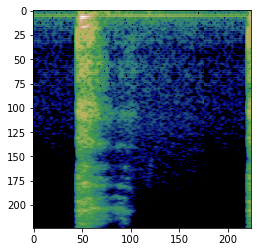

b


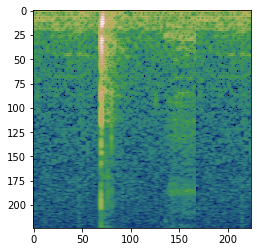

b


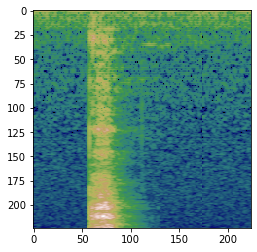

h


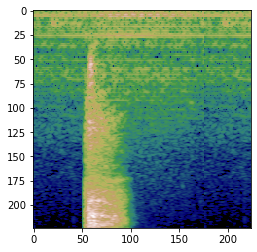

h


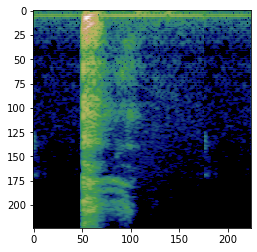

b


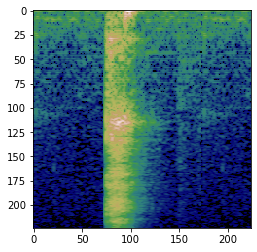

s


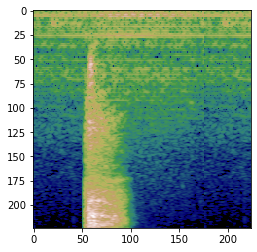

h


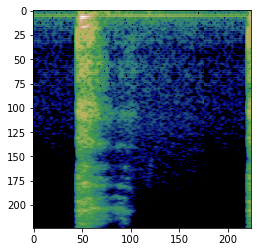

b


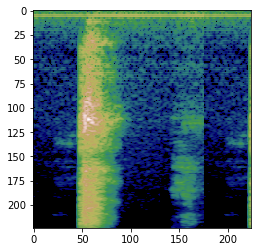

s


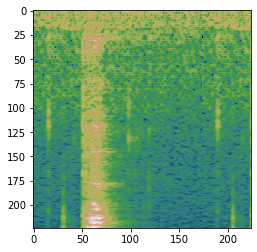

h


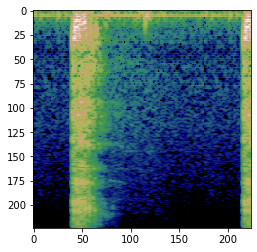

b


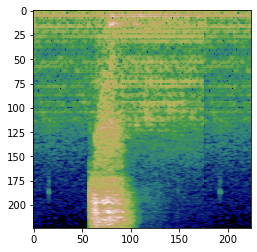

h


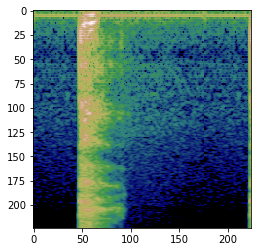

b


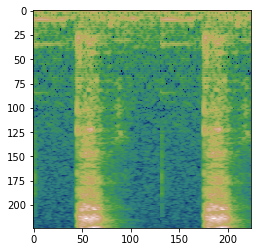

h


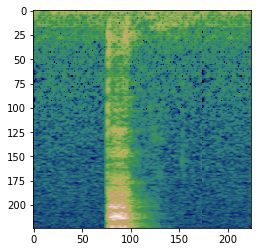

h


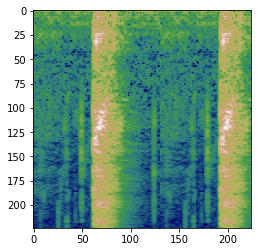

s


In [11]:
#Getting some random training images and showing them
dataiter = iter(trainloader)
images, labels = dataiter.next()
for i in range(trainloader.batch_size):
    imshow(images[i])
    print(classes[labels[i]])

## Specify use of Graphics Card (if there is one) and use ResNet

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ('device:', device)
model = models.resnet18(pretrained=False)

device: cpu


## Load pretrained model 
The model '../Models/MainModelUrban.pth' was trained on the UrbanSound dataset; other models could be specified instead.

In [14]:
ModelData = torch.load('../Models/MainModelUrban.pth',map_location='cpu')
model.load_state_dict(ModelData['model'])

<All keys matched successfully>

## Cutting off the head
In the following cell, the setting 'param.requires_grad = False' is **the** function that is telling the network to only retrain the last layer. If you set this parameter to True, the training will take much longer, but hopefully be better at predicting. 

In [15]:
'''
For each parameter in the network we turn of training, 
by setting  .requires_grad  to `False`.

This makes sure that the computer will not try to adjust thos variables when "training".
'''
for param in model.parameters(): #
    param.requires_grad = False #... 
    
'''
'fc' stands for "fully connected" and it is the very last layer in the neural net.
We replace this layer with a new fully connected layer, that connects the 512 input neurons to neurons for our classes.
'''    
model.fc = nn.Linear(512, len(classes)) 

## Move model to GPU (if there is a GPU)

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_epoch_losses=[]
test_epoch_losses=[]
epoch=0

## Training the network

In [17]:
#Training the network on the training dataset
for i in range(5):  # loop over the dataset multiple (5) times 
    epoch+=1
    print("Starting epoch:",epoch)
    epochLoss=0.0
    t0 = time.time()
    model.train()
    for i, data in enumerate(trainloader, 0):
        #print("Running Batches",i)
        # get the inputs
        inputs, labels = data
        if device.type=='cuda':
            inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        if((i+i)%50==0):
            if(i>0):
                print('Processed images:',i*trainloader.batch_size,'. Running Timer @ {:.2f}sec.'.format(time.time()-t0))
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epochLoss+=loss.item()
        
    
    model.eval()
    testLoss=0
    print("About to test the performance on the test set.")
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            # get the inputs
            inputs, labels = data
            if device.type=='cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            testLoss+=loss.item()
            if(i%50==0):
                if(i>0):
                    print('Tested images:',i*testloader.batch_size,'. Running Timer @ {:.2f}sec.'.format(time.time()-t0))


    train_epoch_losses.append(epochLoss/len(trainloader))
    test_epoch_losses.append(testLoss/len(testloader))
    EpochLength = time.time()-t0
    print('{} train loss: {:.3f} and test loss: {:.3f}, and it took us: {:.2f} seconds.'.format (epoch + 1, epochLoss / len(trainloader),testLoss/len(testloader),EpochLength))  # DAVID CHanged it to 1000 from 2000 not sure if thats totally done
print('Finished Training')


Starting epoch: 1
About to test the performance on the test set.
2 train loss: 1.167 and test loss: 1.073, and it took us: 16.45 seconds.
Starting epoch: 2
About to test the performance on the test set.
3 train loss: 1.035 and test loss: 0.903, and it took us: 16.56 seconds.
Starting epoch: 3
About to test the performance on the test set.
4 train loss: 0.885 and test loss: 0.780, and it took us: 16.69 seconds.
Starting epoch: 4
About to test the performance on the test set.
5 train loss: 0.786 and test loss: 0.698, and it took us: 16.87 seconds.
Starting epoch: 5
About to test the performance on the test set.
6 train loss: 0.746 and test loss: 0.639, and it took us: 16.89 seconds.
Finished Training


## Post training analytics

After the training has finished, save information about the training

In [18]:
# saving the learnd model in file that can be loaded in for inference
torch.save({
    'model':model.state_dict(),
    'classes':classes,
    'resolution':224,
    'modelType':"resnet18" # <= If you try out different models make sure to change this too
},"../models/CatDogResNet.pth") # <=Edit file name here 

Display how the traing and test loss progressed over successive epochs

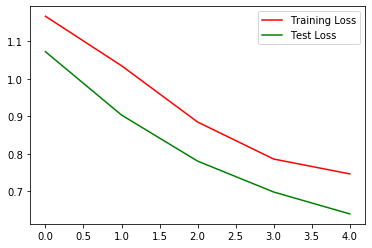

In [19]:
#Displaying how the loss progresses over time.
plt.plot(train_epoch_losses, label='Training Loss',c='r')
plt.plot(test_epoch_losses, label='Test Loss',c='g')
plt.legend()
plt.show()

Show spectagrams, Predicted and Actual labels.

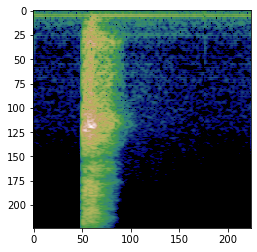

GroundTruth:  s
Predicted:  s


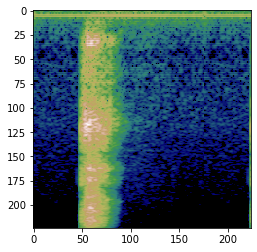

GroundTruth:  s
Predicted:  s


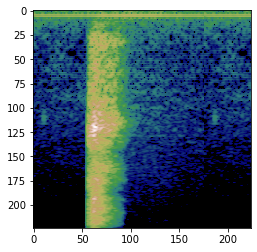

GroundTruth:  s
Predicted:  s


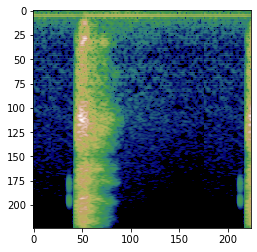

GroundTruth:  s
Predicted:  s


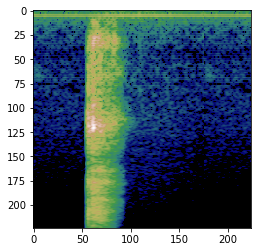

GroundTruth:  s
Predicted:  s


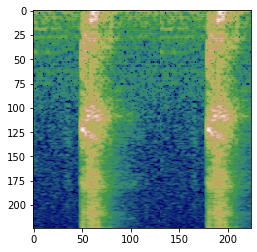

GroundTruth:  s
Predicted:  h


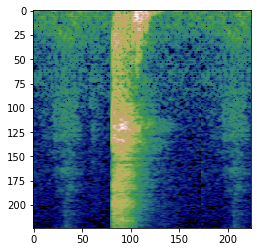

GroundTruth:  s
Predicted:  b


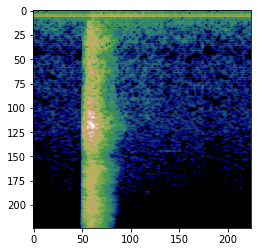

GroundTruth:  s
Predicted:  s


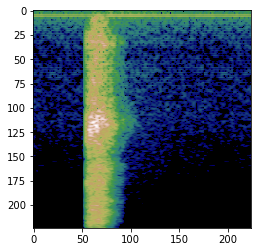

GroundTruth:  s
Predicted:  s


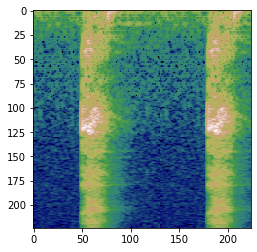

GroundTruth:  s
Predicted:  s


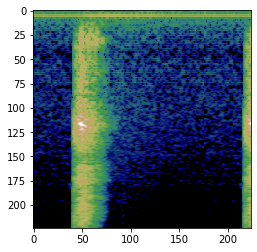

GroundTruth:  s
Predicted:  s


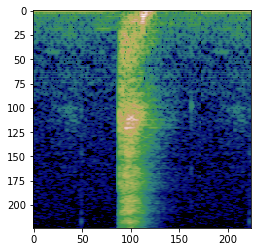

GroundTruth:  s
Predicted:  b


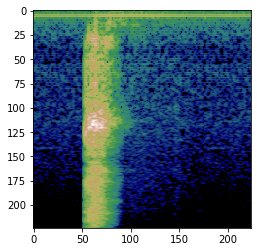

GroundTruth:  s
Predicted:  s


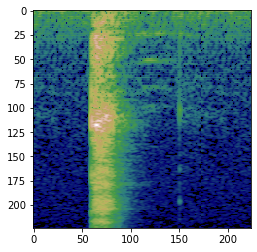

GroundTruth:  s
Predicted:  s


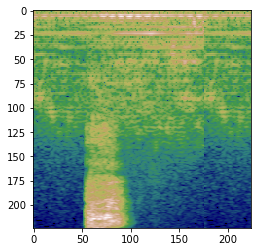

GroundTruth:  h
Predicted:  h


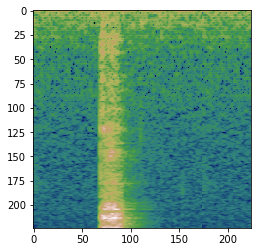

GroundTruth:  h
Predicted:  h


In [20]:
# Print predicted and acual labels for Spectragrams
model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
for i in range(trainloader.batch_size):
    imshow(images[i].cpu())
    print('GroundTruth: ',classes[labels[i]])
    print('Predicted: ',  classes[predicted[i]])


Print accuracy of test predictions for each label

In [21]:
# Network analytics
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
model.eval()
allLabels=[]
allPrediction=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if (c.dim()==0):
            continue
        for i in range(testloader.batch_size):
            if(len(labels)<=i):
                continue;
            label = labels[i]
            allLabels.append(labels[i].to('cpu').numpy())
            allPrediction.append(predicted[i].to('cpu').numpy())
            #print (c.shape)
            if(testloader.batch_size>1):

                class_correct[label] += c[i].item()
            else:
                class_correct[label] += c.item()
            class_total[label] += 1

print(confusion_matrix(allLabels, allPrediction))
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

[[11  1  2]
 [ 0 15  0]
 [ 4  2 10]]
Accuracy of     s : 78 %
Accuracy of     h : 100 %
Accuracy of     b : 62 %


5 Epoch:
[[2126 1362]
 [ 426 4373]]
Accuracy of  Dogs : 60 %
Accuracy of  Cats : 91 %